<a href="https://colab.research.google.com/github/tammy-uncc/ITCS6162KDDGroup4/blob/main/KDD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITCS 6162 KDD Group 4 Final Project


## Team Members
Julie Berryhill<br>
Gabriel Van Dreel<br>
Dasha Rizvanova<br>
Manoj Aitha<br>
Tammy Ziegler<br>


## Introduction

Group 4 decided that they would like to research the possibility of whether an individual could change their lifestyle factors in time to reduce or eliminate the onset of Alzheimer's. For example, if an individual knew that a healthier diet could reduce their chance of a positive diagnosis, then they may put eating healthier as an earlier priority in their lives. This dataset includes many lifestyle factors (BMI, smoking status, alcohol consumption, physical activity, diet quality, and sleep quality) that will help in building predictive and prescriptive objectives.
We will be using supervised learning methods as the diagnosis of Alzheimer's is a known outcome in this dataset.

We will be looking into classification, clustering, and feature selection to identify and select the most relevant features to improve the predictive models. By using these approaches, group 4 hopes that this research will uncover any insights of lifestyle risk factors for developing Alzheimer's and which lifestyle factor modifications could mitigate those risks.



## Research Question
Are there any lifestyle factors that could be changed to reduce or eliminate the onset of Alzheimer's?

## Data Source
https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset?select=alzheimers_disease_data.csv

The dataset consists of 2150 entries detailing various physiological characteristics of patients who were considered for an Alzheimer's disease diagnosis and whether they were formally diagnosed with the illness. Some of the data such as the gender and ethnicity columns is categorical while other data is numeric and represents either an index for a rating of some condition such as sleep quality or a direct measurement of some physical characteristic such as cholesterol. All of the numeric data points could be considered time series data concerning age. Some columns in the dataset such as the name of the doctor in charge of a given patient, however, have been sanitized and provide no meaningful information.


## Data Analysis

Through our analysis, we identified some features that can be dropped since they provide no value to our research.  We also discovered that only a few features have some semblance of correlation with the diagnosis.  The diagnosis itself is a bit weighted as only a third of the observations are a positive diagnosis. Hence we need to consider that when reviewing the relationships with the other features of the data set.



In [ ]:
# Mount your google drive - not required unless the dataset file is stored on your google drive.
# If not, see the instructions for loading the data.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# install ydata-profiling into the environment
#
# ##*** Note that this cell may cause the kernel to restart.  This is normal and is okay to proceed **##
#
!pip install ydata_profiling
!pip install --upgrade Pillow
!pip install pycaret

In [ ]:
# Restart kernel
#
# If the previous cell did not restart the kernel, run this cell to restart it.
# This will make sure the new packages are available to the session kernel.
#
import os
os._exit(00)


### Import the required modules

In [ ]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt
from pycaret.classification import setup,compare_models,tune_model,finalize_model,predict_model,interpret_model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.outliers_influence as inf
import statsmodels.api as sm
from ydata_profiling import ProfileReport


### Load the data and drop known unnecessary features
Patient ID is a numeric identifier and has no value to the dataset other than to represent a unique individual.  DoctorInCharge is also unnecessary as it provides no value to the data.

#### Instructions:
The Alzheimer data will need to be loaded to the collab environment if you are using collab.

Download the data from:
https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset?select=alzheimers_disease_data.csv

Then upload it to the collab session storage. Click the upload icon
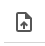
in the upper left under the label 'Files'.

In [ ]:
# Load the data  - see instructions in above cell

try: # Try reading from the google drive
  df = pd.read_csv('alzheimers_disease_data.csv')
except: # Read from session space
  try:
    df = pd.read_csv('/content/drive/MyDrive/ITCS 6162/alzheimers_disease_data.csv')
  except:
    print("Copy the data to session storage. See markdown for this cell.")


df = df.drop(['DoctorInCharge','PatientID'], axis=1)

# Show a sample of the data
df.head()

In [ ]:
# Show information about the columns

df.info()

In the following sections, we will perform various operations on the data to visualize from multiple perspectives.


### Profile the data
To start we will use the profiler tool to get an initial profile of the data. This will produce a report and save it as an html file.


In [ ]:
profile = ProfileReport(df, title="Alzheimer's Data Profile Report")
try:    # Try saving to the google drive
  profile.to_file("/content/drive/MyDrive/ITCS 6162/alzheimers_report.html")
except: # Save to the session space
  profile.to_file("alzheimers_report.html")

profile.to_notebook_iframe()

### Perform a correlation of all features
This map is annotated to see the values.

In [ ]:


corr = df.corr()
plt.figure(figsize=(30,30))
plt.title('All')
sns.heatmap(corr,annot=True)



### Prepare for other visualizations
Create functions and data for density and distribution plots.

In [ ]:

groups = {'category': ['Ethnicity', 'Gender', 'EducationLevel',
               'Smoking','FamilyHistoryAlzheimers',
               'CardiovascularDisease', 'Diabetes','Depression', 'HeadInjury',
               'Hypertension','MemoryComplaints','BehavioralProblems',
               'Confusion','Disorientation',
               'PersonalityChanges','DifficultyCompletingTasks',
               'Forgetfulness','Diagnosis'],
          'numeric': ['Age', 'BMI','AlcoholConsumption','PhysicalActivity',
               'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP',
               'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides','MMSE',
               'FunctionalAssessment',
               'ADL']
}

categorylabels = {
    'Diagnosis' :['No', 'Yes'],
    'Gender': ['Male', 'Female'],
    'Ethnicity': ['Caucasian', 'African American', 'Asian', 'Other'],
    'EducationLevel': ['None', 'High School', 'Bachelor\'s', 'Higher'],
    'Smoking': ['No', 'Yes'],
    'FamilyHistoryAlzheimers': ['No', 'Yes'],
    'CardiovascularDisease': ['No', 'Yes'],
    'Diabetes': ['No', 'Yes'],
    'Depression': ['No', 'Yes'],
    'HeadInjury': ['No', 'Yes'],
    'Hypertension': ['No', 'Yes'],
    'MemoryComplaints': ['No', 'Yes'],
    'BehavioralProblems': ['No', 'Yes'],
    'Confusion': ['No', 'Yes'],
    'Disorientation': ['No', 'Yes'],
    'PersonalityChanges': ['No', 'Yes'],
    'DifficultyCompletingTasks': ['No', 'Yes'],
    'Forgetfulness': ['No', 'Yes']
}

def distributionPlot(col1, col2):
  ct = pd.crosstab(df[col1], df[col2], normalize='all')

  # get the total for each row
  total = ct.sum(axis=1)

  # set the colors for each Class
  segment_colors = {'0': 'white', '1': 'blue'}

  # calculate the percent for each row
  per = ct.div(total, axis=0).mul(100).round(2)  # iterate through the containers

  ax = ct.plot(kind='bar', stacked=True)
  plt.legend(categorylabels[col2],title=col2)
  plt.xticks(range(len(categorylabels[col1])), categorylabels[col1])
  for c in ax.containers:

      # get the current segment label (a string); corresponds to column / legend
      label = c.get_label()

      # create labels with the percent
      labels = [f'{row}%' if v.get_height() > 0 else '' for v, row in zip(c, per[int(label)])]

      # add the annotation
      ax.bar_label(c, labels=labels, label_type='center', fontweight='bold', color=segment_colors[label])

def densityPlot(col1, col2):
  plt.figure(col1)
  sns.kdeplot(df[df[col2]==1][col], color='red',fill=True)
  sns.kdeplot(df[df[col2]==0][col], color='green',fill=True)
  plt.title(f'Density plot for {col1}')
  plt.legend(categorylabels[col2])
  plt.show

def swarmPlot(col1,col2,col3):
  plt.figure(col1+col2+col3)
  sns.swarmplot(data=df, x=col1, y=col2, hue=col3, size=3)
  plt.xticks(range(len(categorylabels[col1])), categorylabels[col1])


### Checking for multicollinearity
Checking for collinearity on the numeric.

All these features show to be uncorrelated.

In [ ]:
#X=pd.DataFrame(df[['MMSE','FunctionalAssessment','ADL',
#                   'CholesterolTriglycerides',
#                   'CholesterolHDL','SystolicBP','CholesterolLDL',
#                  'SleepQuality','DietQuality','BMI']])

X=pd.DataFrame(df[groups['numeric']])

pd.plotting.scatter_matrix(X,figsize=(20,20))
X= sm.add_constant(X)
print([inf.variance_inflation_factor(X.values, i) for i in range(X.shape[1])])

The following shows the percentage of each of the diagnosis categories. It shows that the data set contains almost twice as many negative diagnoses as positive ones.

In [ ]:
print(df['Diagnosis'].value_counts())
print(len(df[df['Diagnosis']==0])/len(df))
print(len(df[df['Diagnosis']==1])/len(df))

### Perform density analysis on numeric columns
These graphs will show the relationship of the numeric features with the diagnosis.  The data was split by diagnosis and then each diagnosis set was plotted on the same graph to show where the positive diagnosis lands relative to the negative.

We know the dataset has a weighted diagnosis of approximately 64% negative and 36% positive. So, if the feature has little to no impact on the diagnosis, then the positive diagnosis plots should be approximately 50% less than the negatives.


In [ ]:
for col in groups['numeric']:
  densityPlot(col, 'Diagnosis')

### Perform a distribution visualization analysis on the categorical data
The following graphs will show how the categorical data is related to the diagnosis.  We are looking to see if there are any significant variations.  We know the dataset has a weighted diagnosis of approximately 64% negative and 36% positive.  We are investigating if any categories in these visualizations have percentages significantly more or less than the above.


In [ ]:

for col in groups['category']:
  distributionPlot(col, 'Diagnosis')


### Swarm plot visualizations
These visualizations will show the distribution of the data’s lifestyle features with some demographic features. The purpose is to determine if any significant patterns appear that may add value to our research.


In [ ]:
swarmPlot('Ethnicity', 'AlcoholConsumption', 'Diagnosis')
swarmPlot('Gender', 'AlcoholConsumption', 'Diagnosis')

swarmPlot('Ethnicity', 'PhysicalActivity', 'Diagnosis')
swarmPlot('Gender', 'PhysicalActivity', 'Diagnosis')

swarmPlot('Ethnicity', 'DietQuality', 'Diagnosis')
swarmPlot('Gender', 'DietQuality', 'Diagnosis')

swarmPlot('Ethnicity', 'SleepQuality', 'Diagnosis')
swarmPlot('Gender', 'SleepQuality', 'Diagnosis')


## Data Preparation

The categorical columns of the Alzheimer's Disease Dataset could be one-hot encoded during data preprocessing. Any of the numeric columns could be standardized such that they reflect a normal distribution if they are found to be normally distributed while others could be linearly scaled to reduce the effect of bias in any machine learning models for the dataset. The sanitized columns in the dataset could also be dropped since they provide no useful information.

### Drop additional features
After reviewing the profile report and other visualizations we found that Ethnicity, Gender, and EducationLevel provide no value to our study. Ethnicity is imbalanced and biased, Gender and Education Levels have about the same diagnosis split as the entire set. We decided we were comfortable removing these from the dataset.

As we continue our research we may determine that other features can be removed.


In [ ]:
# Drop additional columns
df = df.drop(['EducationLevel'], axis=1) # Added back ethnicity and gender
df.head()

### Preprocessing of data

The following section will describe and perform various preprocessing operations.  Later in the document we will explore with other models where we make changes to the dataset and rerun the preprocessing on it.

#### Method declaration
The following method is defined for splitting and scaling to be used throughout this notebook. It will split the data 80/20 and use a MinMax scaler.

In [66]:
# Preprocessing

#
# Split and scale the data
#
def splitScaleData(dataf, target='Diagnosis'):
   """ splitScaleData will split a DataFrame into X and y train and test and 
   then rescale the X data. The split will be 80/20.

   :param dataf: the DataFrame to split and scale
   :param target: the name of the target label column in the DataFrame

   :return: Returns the following six splits; 
         rescaledX_train - the rescaled training split
         rescaledX_test - the rescaled testing split 
         X_train - the unscaled trainging split
         X_test - the unscaled testing split
         y_train - the training labels
         y_test - the test labels
   """
   # Segregate features and labels into separate variables
   X, y = dataf.loc[:, dataf.columns != target] , dataf[target]

   # Split into train and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   # Instantiate MinMaxScaler and use it to rescale X_train and X_test
   scaler = MinMaxScaler(feature_range=(0, 1))

   rescaledX_train = scaler.fit_transform(X_train)
   rescaledX_test = scaler.transform(X_test)
   return rescaledX_train, rescaledX_test, X_train, X_test, y_train, y_test


#### Perform preprocessing
One-hot encoding was performed for the 'Ethnicity' column to reduce the skew of the dataset. A training and test subset of the data was created where 20% of the original data points were allocated for the test set.


In [ ]:
le=LabelEncoder()

# Use LabelEncoder to do the numeric transformation
df['Ethnicity']=le.fit_transform(df['Ethnicity'])
df_ohe = pd.get_dummies(df, columns = ['Ethnicity']).astype(np.float64)

rescaledX_train, rescaledX_test, X_train, X_test, y_train, y_test = splitScaleData(df_ohe, 'Diagnosis')

df_ohe.head()

## Model Evaluation

 A grid search was performed to tune hyperparameters for a logistic regression model and a random forest classifier model that were each selected for their ability to effectively fit a non-linear decision boundary with high generalizability.
 
Although the random forest classifier model has the limitation of having only orthogonal decision boundaries, it was observed to perform binary classification for whether a given patient had alzheimers with the highest accuracy. Each model was analyzed with a number of evaluation criteria where confusion matrices and metrics for precision, recall, and f1-score were evaluated for both the logistic regression model and the random forest classifier model. It was observed that the logistic regression had a more balanced confusion matrix for misclassifications and therefore had a more stable and, in one instance, higher recall than the random forest classifier did with respect to each classification category.




In [ ]:

# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Create a dictionary where tol and max_iter are keys and the lists of their values are the corresponding values
param_grid = {
    "tol": [0.5, 0.1, 0.01, 0.001 ,0.0001],
    "max_iter": [10, 25, 50, 100, 150, 200]
}

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)

# Fit grid_model to the data
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Use logreg to predict instances from the test set and store it
y_pred = grid_model_result.predict(rescaledX_test)

# Print the confusion matrix of the logreg model
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test,y_pred))

In [ ]:

rfc = RandomForestClassifier(random_state=42)

params_rfc = {
    "max_depth": [3, 4, 5, 6],
    "min_samples_leaf": [0.04, 0.06, 0.08],
    "max_features": [0.2, 0.4, 0.6, 0.8]
}

grid_rfc = GridSearchCV(estimator=rfc, param_grid=params_rfc, scoring="accuracy", cv=5, n_jobs=-1)
grid_model_result = grid_rfc.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Use rfc to predict instances from the test set and store it
y_pred = grid_model_result.predict(rescaledX_test)

# Print the confusion matrix of the logreg model
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test,y_pred))

### Evaluation of Dataset Features

For the k=10 best features, univariate statistical tests were performed for the predictive relationship between the input features and class labels used with the trained models. A score representing a proportion of predictive contribution with respect to the 10th-most influential feature to performing accurate classification was generated and sorted in descending order based on a fit to the distribution of data points in each column to a chi squared distribution. It was observed that MMSE, FunctionalAssessment, and ADL were the strongest predictors of an Alzheimer's classification.

In [ ]:


#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_ohe.drop('Diagnosis',axis=1).columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.sort_values(by='Score', ascending=False))

### Using PyCaret to review other models.

PyCaret is a tool that allows you to streamline the process of developing and evaluating a dataset for predictive models. The automation accounts for preprocessing, model selection, tuning, and evaluation. This is an ideal situation when dealing with health datasets.

#### Define methods
The following methods are defined to perform common operations and will be used throughout this notebook.

In [69]:
#
#  Executes PyCaret on a dataset with a given target
#
def runPyCaret(train_df, target, val_df):
   """ runPyCaret will perform the appropriate pycaret methods on the provided
   datasets using the provided target as the label.

   :param train_df: DataFrame containing the training data. This data will be
                   split by PyCaret to fit and test.
   :param target: name of the target column in the dataframes.
   :param val_df: DataFrame containing the validation data.  It is best if  
                  this data has not yet been seen by PyCaret
   """
   # Setting up the PyCaret environment
   clf1 = setup(train_df, target=target, session_id=123, normalize=True, feature_selection=True, remove_multicollinearity=True)

   print("Comparing Models")
   # Comparing multiple models
   best_model = compare_models()

   print("Tuning the best model")
   # Tuning the best model
   tuned_model = tune_model(best_model)

   print("Fitting the best model to the entire dataset")
   # Finalizing the model with PyCaret
   final_model = finalize_model(tuned_model)

   print(f"Perform Predictions on validation data")
   # Predicting on the validation dataset
   new_data = val_df.drop(target, axis=1)
   predictions = predict_model(final_model, data=new_data)

   y_pred = predictions.astype('int')['prediction_label'].values
   y_prob = predictions.astype('int')['prediction_score'].values
   y_lab = val_df['Diagnosis'].values

   print("Confusion matrix:\n", confusion_matrix(y_lab, y_pred))
   print("Classification report:\n", classification_report(y_lab,y_pred))

   # calculate the scores
   print(f"Accuracy = {accuracy_score(y_lab, y_pred)}")
   print(f"Precision = {precision_score(y_lab, y_pred)}")
   print(f"Recall = {recall_score(y_lab, y_pred)}")
   print(f"F1 = {f1_score(y_lab, y_pred)}")
   print(f"AUC = {roc_auc_score(y_lab, y_prob)}")

#
# Randomly sample and split the data
#
def randomSample(dataf, p, seed=None):
   """ randomSample will  split the dataframe into two dataframes. The first 
   dataframe will contain a random sampling of p percent of data from the 
   provided dataframe and the second returned dataframe will contain the
   remaining 1-p percent of data.

   :param dataf: DataFrame to split up
   :param p: percent of data to place in first returned DataFrame
   :return: returns the split dataframe as two dataframes 
   """

   if seed: random.seed = seed
   full=list(range(len(df)))
   lims = random.sample(range(len(dataf)), int(len(dataf)*p))
   not_lims = list(set(full) - set(lims))
   print(len(lims))
   print(len(dataf))
   lim_df = dataf.iloc[lims]
   nlim_df = dataf.iloc[not_lims]
   return lim_df, nlim_df

#
# Over sample the data
#
def overSample(lim_df, target='Diagnosis'):
   """ overSample will rebalance the data in a DataFrame so there are a more
   equal amount of lables represented in the dataset.

   :param lim_df: DataFrame to over sample.
   :param target: name of the target label column.
   :return: returns a dataframe with the over sampled data
   """
   # Split out the target
   X, y = lim_df.loc[:, lim_df.columns != target] , lim_df[target]
   print(f'X len = {len(X)}, y len = {len(y)}')

   # Create an oversample to adjust for the lack of positive cases
   oversample = RandomOverSampler(sampling_strategy='minority')
   X_over, y_over = oversample.fit_resample(X, y)
   print(f'Over: X len = {len(X_over)}, y len = {len(y_over)}')

   # Recreate as a DataFrame
   cols=lim_df.drop('Diagnosis', axis=1).columns
   new_df = pd.DataFrame(X_over)
   new_df.columns = cols
   new_df.insert(len(cols), column=target, value=y_over.values)
   return new_df

#### Run PyCaret on the original dataset

In [68]:
# Use the original dataset in PyCaret and predict on full set
runPyCaret(df_ohe, 'Diagnosis', df_ohe)

,Description,Value
0,Session id,123
1,Target,Diagnosis
2,Target type,Binary
3,Original data shape,"(2149, 36)"
4,Transformed data shape,"(2149, 8)"
5,Transformed train set shape,"(1504, 8)"
6,Transformed test set shape,"(645, 8)"
7,Numeric features,35
8,Preprocess,True
9,Imputation type,simple


Comparing Models


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8245,0.8624,0.6110,0.8518,0.7094,0.5891,0.6071,0.5080
rf,Random Forest Classifier,0.8225,0.8602,0.5978,0.8604,0.7024,0.5824,0.6038,0.5200
lightgbm,Light Gradient Boosting Machine,0.8152,0.8493,0.6430,0.7980,0.7099,0.5770,0.5859,0.8640
et,Extra Trees Classifier,0.8125,0.8414,0.5884,0.8384,0.6876,0.5601,0.5805,0.5030
ada,Ada Boost Classifier,0.8085,0.8566,0.6486,0.7763,0.7041,0.5647,0.5716,0.5120
lr,Logistic Regression,0.7846,0.8215,0.6090,0.7409,0.6655,0.5093,0.5167,0.4580
qda,Quadratic Discriminant Analysis,0.7826,0.8235,0.5920,0.7462,0.6570,0.5015,0.5107,0.4730
ridge,Ridge Classifier,0.7820,0.8211,0.5958,0.7412,0.6575,0.5009,0.5093,0.4910
lda,Linear Discriminant Analysis,0.7806,0.8211,0.6071,0.7337,0.6609,0.5014,0.5088,0.4640
nb,Naive Bayes,0.7786,0.8273,0.5770,0.7441,0.6462,0.4897,0.5005,0.4680


Tuning the best model


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8477,0.9059,0.5849,0.9688,0.7294,0.6322,0.6712
1,0.8146,0.8390,0.4906,0.9630,0.6500,0.5413,0.5983
2,0.8146,0.8286,0.5185,0.9333,0.6667,0.5523,0.5981
3,0.8477,0.8706,0.6111,0.9429,0.7416,0.6404,0.6707
4,0.8400,0.8621,0.5849,0.9394,0.7209,0.6171,0.6511
5,0.8400,0.8640,0.6415,0.8718,0.7391,0.6276,0.6429
6,0.8067,0.8652,0.4906,0.9286,0.6420,0.5262,0.5765
7,0.8333,0.8633,0.5283,1.0000,0.6914,0.5916,0.6481
8,0.8733,0.8656,0.6604,0.9722,0.7865,0.7011,0.7276


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting the best model to the entire dataset


shape of predictions: (2149,)
Confusion matrix:
 [[1368   21]
 [ 281  479]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.98      0.90      1389
         1.0       0.96      0.63      0.76       760

    accuracy                           0.86      2149
   macro avg       0.89      0.81      0.83      2149
weighted avg       0.88      0.86      0.85      2149

Accuracy = 0.8594695207073058
Precision = 0.958
Recall = 0.6302631578947369
F1 = 0.7603174603174603
AUC = 0.5


# Run the One Hot Encoded dataset through PyCaret

In [65]:
# Use the one hot encoding data in PyCaret and predict on full set
runPyCaret(df_ohe, 'Diagnosis', df_ohe)

,Description,Value
0,Session id,123
1,Target,Diagnosis
2,Target type,Binary
3,Original data shape,"(2149, 36)"
4,Transformed data shape,"(2149, 8)"
5,Transformed train set shape,"(1504, 8)"
6,Transformed test set shape,"(645, 8)"
7,Numeric features,35
8,Preprocess,True
9,Imputation type,simple


Comparing Models


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8245,0.8624,0.6110,0.8518,0.7094,0.5891,0.6071,0.4950
rf,Random Forest Classifier,0.8225,0.8602,0.5978,0.8604,0.7024,0.5824,0.6038,0.5340
lightgbm,Light Gradient Boosting Machine,0.8152,0.8493,0.6430,0.7980,0.7099,0.5770,0.5859,0.8330
et,Extra Trees Classifier,0.8125,0.8414,0.5884,0.8384,0.6876,0.5601,0.5805,0.4740
ada,Ada Boost Classifier,0.8085,0.8566,0.6486,0.7763,0.7041,0.5647,0.5716,0.4890
lr,Logistic Regression,0.7846,0.8215,0.6090,0.7409,0.6655,0.5093,0.5167,0.4640
qda,Quadratic Discriminant Analysis,0.7826,0.8235,0.5920,0.7462,0.6570,0.5015,0.5107,0.4820
ridge,Ridge Classifier,0.7820,0.8211,0.5958,0.7412,0.6575,0.5009,0.5093,0.4880
lda,Linear Discriminant Analysis,0.7806,0.8211,0.6071,0.7337,0.6609,0.5014,0.5088,0.4430
nb,Naive Bayes,0.7786,0.8273,0.5770,0.7441,0.6462,0.4897,0.5005,0.4840


Tuning the best model


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8477,0.9059,0.5849,0.9688,0.7294,0.6322,0.6712
1,0.8146,0.8390,0.4906,0.9630,0.6500,0.5413,0.5983
2,0.8146,0.8286,0.5185,0.9333,0.6667,0.5523,0.5981
3,0.8477,0.8706,0.6111,0.9429,0.7416,0.6404,0.6707
4,0.8400,0.8621,0.5849,0.9394,0.7209,0.6171,0.6511
5,0.8400,0.8640,0.6415,0.8718,0.7391,0.6276,0.6429
6,0.8067,0.8652,0.4906,0.9286,0.6420,0.5262,0.5765
7,0.8333,0.8633,0.5283,1.0000,0.6914,0.5916,0.6481
8,0.8733,0.8656,0.6604,0.9722,0.7865,0.7011,0.7276


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting the best model to the entire dataset


shape of predictions: (2149,)
Confusion matrix:
 [[1368   21]
 [ 281  479]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.98      0.90      1389
         1.0       0.96      0.63      0.76       760

    accuracy                           0.86      2149
   macro avg       0.89      0.81      0.83      2149
weighted avg       0.88      0.86      0.85      2149

Accuracy = 0.8594695207073058
Precision = 0.958
Recall = 0.6302631578947369
F1 = 0.7603174603174603
AUC = 0.5


#### Use the One Hot Encoded data, rebalance and run through PyCaret

In [67]:
# Take 80/20 Random samples on one hot encoded data
# Fit with the 80 and predict with the 20
df_lim, df_nlim = randomSample(df_ohe, .8)

df_os = overSample(df_lim, 'Diagnosis')

# Use just the unseen values in df_nlim for validation
runPyCaret(df_os, 'Diagnosis', df_nlim)

1719
2149
X len = 1719, y len = 1719
Over: X len = 2214, y len = 2214
[LightGBM] [Info] Number of positive: 775, number of negative: 774
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3306
[LightGBM] [Info] Number of data points in the train set: 1549, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500323 -> initscore=0.001291
[LightGBM] [Info] Start training from score 0.001291


,Description,Value
0,Session id,123
1,Target,Diagnosis
2,Target type,Binary
3,Original data shape,"(2214, 36)"
4,Transformed data shape,"(2214, 8)"
5,Transformed train set shape,"(1549, 8)"
6,Transformed test set shape,"(665, 8)"
7,Numeric features,35
8,Preprocess,True
9,Imputation type,simple


Comparing Models


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9006,0.9459,0.8968,0.9041,0.9002,0.8011,0.8015,0.5320
et,Extra Trees Classifier,0.8999,0.9457,0.8891,0.9091,0.8988,0.7998,0.8002,0.5000
lightgbm,Light Gradient Boosting Machine,0.8967,0.9415,0.9007,0.8944,0.8973,0.7934,0.7938,0.8760
dt,Decision Tree Classifier,0.8547,0.8546,0.8903,0.8324,0.8601,0.7094,0.7115,0.5030
gbc,Gradient Boosting Classifier,0.8508,0.9248,0.8142,0.8800,0.8455,0.7016,0.7040,0.5160
ada,Ada Boost Classifier,0.8108,0.8941,0.8232,0.8045,0.8133,0.6216,0.6224,0.5290
knn,K Neighbors Classifier,0.7682,0.8492,0.7847,0.7605,0.7720,0.5364,0.5372,0.4940
qda,Quadratic Discriminant Analysis,0.7682,0.8397,0.7368,0.7870,0.7609,0.5365,0.5378,0.5440
nb,Naive Bayes,0.7644,0.8331,0.7393,0.7797,0.7586,0.5287,0.5300,0.4870
lr,Logistic Regression,0.7502,0.8395,0.7548,0.7504,0.7518,0.5003,0.5014,0.7130


Tuning the best model


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9161,0.9665,0.8831,0.9444,0.9128,0.8322,0.8339
1,0.8516,0.9259,0.7532,0.9355,0.8345,0.7028,0.7164
2,0.8581,0.9242,0.7922,0.9104,0.8472,0.7159,0.7219
3,0.7935,0.8801,0.6883,0.8689,0.7681,0.5865,0.5995
4,0.8774,0.9426,0.8333,0.9155,0.8725,0.7550,0.7581
5,0.8129,0.9138,0.7436,0.8657,0.8000,0.6261,0.6325
6,0.8258,0.9309,0.7436,0.8923,0.8112,0.6520,0.6613
7,0.8129,0.8830,0.7179,0.8889,0.7943,0.6263,0.6383
8,0.8323,0.9139,0.7821,0.8714,0.8243,0.6647,0.6683


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Fitting the best model to the entire dataset


shape of predictions: (430,)
Confusion matrix:
 [[265  17]
 [ 35 113]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       282
         1.0       0.87      0.76      0.81       148

    accuracy                           0.88       430
   macro avg       0.88      0.85      0.86       430
weighted avg       0.88      0.88      0.88       430

Accuracy = 0.8790697674418605
Precision = 0.8692307692307693
Recall = 0.7635135135135135
F1 = 0.8129496402877698
AUC = 0.5097996933103316


### Rebalance the data and use Random Forest

In [71]:
## Perform a random forest on over sampled data knowing that it was the best model

df_lim, df_nlim = randomSample(df_ohe, .8)

df_os = overSample(df_lim, 'Diagnosis')

rescaledX_train, rescaledX_test, X_train, X_test, y_train, y_test = splitScaleData(df_os, 'Diagnosis')

X_val, y_val = df_nlim.loc[:, df_nlim.columns != 'Diagnosis'] , df_nlim['Diagnosis']

rfc = RandomForestClassifier(random_state=42)

params_rfc = {
    "max_depth": [3, 4, 5, 6],
    "min_samples_leaf": [0.04, 0.06, 0.08],
    "max_features": [0.2, 0.4, 0.6, 0.8]
}

grid_rfc = GridSearchCV(estimator=rfc, param_grid=params_rfc, scoring="accuracy", cv=5, n_jobs=-1)
grid_model_result = grid_rfc.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

print("\nPredcit on the rescaled test data")
# Use rfc to predict instances from the test set and store it
y_pred = grid_model_result.predict(rescaledX_test)
y_prob = grid_model_result.predict_proba(rescaledX_test)

# Print the confusion matrix of the logreg model
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test,y_pred))

# calculate the scores
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"Precision = {precision_score(y_test, y_pred)}")
print(f"Recall = {recall_score(y_test, y_pred)}")
print(f"F1 = {f1_score(y_test, y_pred)}")
print(f"AUC 0 = {roc_auc_score(y_test.values, y_prob[:,0])}")
print(f"AUC 1  = {roc_auc_score(y_test.values, y_prob[:,1])}")


print("\nPredcit on the rescaled validation data")

scaler = MinMaxScaler(feature_range=(0, 1))

X_val_scaled = scaler.fit_transform(X_val)
y_pred = grid_model_result.predict(X_val_scaled)
y_prob = grid_model_result.predict_proba(X_val_scaled)

# Print the confusion matrix of the logreg model
print("Confusion matrix:\n", confusion_matrix(y_val.values, y_pred))
print("Classification report:\n", classification_report(y_val.values,y_pred))

# calculate the scores
print(f"Accuracy = {accuracy_score(y_val, y_pred)}")
print(f"Precision = {precision_score(y_val, y_pred)}")
print(f"Recall = {recall_score(y_val, y_pred)}")
print(f"F1 = {f1_score(y_val, y_pred)}")
print(f"AUC 0 = {roc_auc_score(y_val.values, y_prob[:,0])}")
print(f"AUC 1  = {roc_auc_score(y_val.values, y_prob[:,1])}")


1719
2149
X len = 1719, y len = 1719
Over: X len = 2208, y len = 2208
Best: 0.938276 using {'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 0.04}

Predcit on the rescaled test data
Confusion matrix:
 [[213  15]
 [ 23 191]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       228
         1.0       0.93      0.89      0.91       214

    accuracy                           0.91       442
   macro avg       0.91      0.91      0.91       442
weighted avg       0.91      0.91      0.91       442

Accuracy = 0.9140271493212669
Precision = 0.9271844660194175
Recall = 0.8925233644859814
F1 = 0.9095238095238095
AUC 0 = 0.05714051483849812
AUC 1  = 0.9428594851615018

Predcit on the rescaled validation data
Confusion matrix:
 [[270  15]
 [ 25 120]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       285
         1.0       0.89      0.8

In [ ]:
yy = df_nlim['Diagnosis']
print(yy.value_counts())
print(len(yy))

## Citations
@misc{rabie_el_kharoua_2024,<br>
title={Alzheimer's Disease Dataset},<br>
url={https://www.kaggle.com/dsv/8668279},<br>
DOI={10.34740/KAGGLE/DSV/8668279},<br>
publisher={Kaggle},<br>
author={Rabie El Kharoua},<br>
year={2024}<br>
}

@article{scikit-learn,<br>
 title={Scikit-learn: Machine Learning in {P}ython},<br>
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.<br>
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.<br>
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and<br>
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},<br>
 journal={Journal of Machine Learning Research},<br>
 volume={12},<br>
 pages={2825--2830},<br>
 year={2011}<br>
}

@ARTICLE{2020NumPy-Array,<br>
  author  = {Harris, Charles R. and Millman, K. Jarrod and<br>
            van der Walt, Stéfan J and Gommers, Ralf and<br>
            Virtanen, Pauli and Cournapeau, David and<br>
            Wieser, Eric and Taylor, Julian and Berg, Sebastian and<br>
            Smith, Nathaniel J. and Kern, Robert and Picus, Matti and<br>
            Hoyer, Stephan and van Kerkwijk, Marten H. and<br>
            Brett, Matthew and Haldane, Allan and<br>
            Fernández del Río, Jaime and Wiebe, Mark and<br>
            Peterson, Pearu and Gérard-Marchant, Pierre and<br>
            Sheppard, Kevin and Reddy, Tyler and Weckesser, Warren and<br>
            Abbasi, Hameer and Gohlke, Christoph and<br>
            Oliphant, Travis E.},<br>
  title   = {Array programming with {NumPy}},<br>
  journal = {Nature},<br>
  year    = {2020},<br>
  volume  = {585},<br>
  pages   = {357–362},<br>
  doi     = {10.1038/s41586-020-2649-2}<br>
}

@Article{Hunter:2007,<br>
  Author    = {Hunter, J. D.},<br>
  Title     = {Matplotlib: A 2D graphics environment},<br>
  Journal   = {Computing in Science \& Engineering},<br>
  Volume    = {9},<br>
  Number    = {3},<br>
  Pages     = {90--95},<br>
  abstract  = {Matplotlib is a 2D graphics package used for Python for<br>
  application development, interactive scripting, and publication-quality<br>
  image generation across user interfaces and operating systems.},<br>
  publisher = {IEEE COMPUTER SOC},<br>
  doi       = {10.1109/MCSE.2007.55},<br>
  year      = 2007<br>
}

@software{the_pandas_development_team_2023_8364959,
  author       = {The pandas development team},<br>
  title        = {pandas-dev/pandas: Pandas},<br>
  month        = sep,<br>
  year         = 2023,<br>
  note         = {If you use this software, please cite it as below.},<br>
  publisher    = {Zenodo},<br>
  version      = {v2.1.1},<br>
  doi          = {10.5281/zenodo.8364959},<br>
  url          = {https://doi.org/10.5281/zenodo.8364959}<br>
}

cff-version: 1.2.0<br>
message: "If seaborn is integral to a scientific publication, please cite the following paper:"<br>
preferred-citation:<br>
  type: article<br>
  authors:<br>
  - family-names: "Waskom"<br>
    given-names: "Michael Lawrence"<br>
    orcid: "https://orcid.org/0000-0002-9817-6869"<br>
  doi: "10.21105/joss.03021"<br>
  journal: "Journal of Open Source Software"<br>
  month: April<br>
  title: "seaborn: statistical data visualization"<br>
  issue: 6<br>
  volume: 60<br>
  year: 2021<br>
  url: "https://joss.theoj.org/papers/10.21105/joss.03021"<br>

